## __MNIST로 CNN 분류기 구현하기__
2022.04.30 @Yeji Choi

In [ ]:
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

- __MNIST(Modified National Institute of Standards and Technology) Dataset__
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/mnist.png" width="400px" height="250px" >

MNIST는 유명한 데이터이기 때문에 pytorch에서 쉽게 사용할 수 있도록 API를 제공함.
 1) 데이터를 다운받을 것인지 아닌지를 체크하고,  
 2) train인지 val인지를 체크하고,   
 3) image를 tensor로 바꾸고,   
 4) normalize시키는 옵션을 사용할지 여부를 명시하면 됨.  


- 제공되는 API  

__torchvision.datasets.데이터셋 명__( root,  train = True , transform = None, target_transform = None, download = False)  

root - 데이터셋을 저장할 디렉토리 위치  
train - 다운받을 데이터셋 종류(train/val/test)  
download - True로 할 경우, 인터넷에서 데이터셋을 root 경로에 다운받는다. 데이터가 있을 경우, 재다운하지 않는다.  
transform - 이미지를 변형한다.  

- _transform_: Data augment   
transforms.CenterCrop(size) - 가운데 부분을 size 크기로 자른다.  
transforms.Grayscale(num_output_channels=1) - grayscale로 변환한다.  
transforms.RandomCrop(size) -이미지를 랜덤으로 아무데나 잘라 size 크기로 출력한다.  
transforms.RandomRotation(degrees) 이미지를 랜덤으로 degrees 각도로 회전한다.  
transforms.RandomResizedCrop(size, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)) - 이미지를 랜덤으로 변형한다.  
transforms.RandomVerticalFlip(p=0.5) - 이미지를 랜덤으로 수직으로 뒤집는다. p =0이면 뒤집지 않는다.  
transforms.RandomHorizontalFlip(p=0.5) - 이미지를 랜덤으로 수평으로 뒤집는다.  
__transforms.ToTensor()__ - 이미지 데이터를 tensor로 바꿔준다.  
__transforms.Normalize__(mean, std, inplace=False) - 이미지를 정규화한다.  

In [ ]:
trn_dataset = datasets.MNIST('./mnist_data/',
                             download=True,
                             train=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(), # image to Tensor
                                 transforms.Normalize((0.1307,), (0.3081,)) # image, label
                             ])) 

val_dataset = datasets.MNIST("./mnist_data/", 
                             download=True,
                             train=False,
                             transform= transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307, ),(0.3081, ))
                           ]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  3


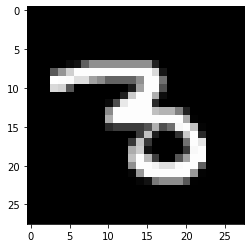

In [ ]:
import torchvision
import matplotlib.pyplot as plt

one_image, label = trn_dataset[30]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
plt.show()

In [ ]:
batch_size = 64
trn_loader = torch.utils.data.DataLoader(trn_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)

__Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')__  

_in_channels_: 입력 채널 수을 뜻합니다. 흑백 이미지일 경우 1, RGB 값을 가진 이미지일 경우 3 을 가진 경우가 많습니다.  
_out_channels_: 출력 채널 수을 뜻합니다.  
_kernel_size_: 커널 사이즈를 뜻합니다. int 혹은 tuple이 올 수 있습니다.  
_stride_: stride 사이즈를 뜻합니다. int 혹은 tuple이 올 수 있습니다. 기본 값은 1입니다.  
_padding_: padding 사이즈를 뜻합니다. int 혹은 tuple이 올 수 있습니다. 기본 값은 0입니다.  
_padding_mode_: padding mode를 설정할 수 있습니다. 기본 값은 'zeros' 입니다. 아직 zero padding만 지원 합니다.  
_dilation_: 커널 사이 간격 사이즈를 조절 합니다. 해당 링크를 확인 하세요.  
_groups_: 입력 층의 그룹 수을 설정하여 입력의 채널 수를 그룹 수에 맞게 분류 합니다.   그 다음, 출력의 채널 수를 그룹 수에 맞게 분리하여, 입력 그룹과 출력 그룹의 짝을 지은 다음 해당 그룹 안에서만 연산이 이루어지게 합니다.  
_bias_: bias 값을 설정 할 지, 말지를 결정합니다. 기본 값은 True 입니다.

- Dilated convolution   
![dilated convolution](./dilated_conv.gif)

#### __LeNet-5__를 이용하여 모델 구축하기

<img src="http://drive.google.com/uc?export=view&id=1n2wQqJc-KRUgZSkO5k_7702ACaVVQ2Kq" width="1000px" height="400px" >

In [ ]:
class CNNClassifier(nn.Module):
    
    def __init__(self):
        # 항상 torch.nn.Module을 상속받고 시작
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 6, 5, 1) #(input channle, output channel, filter size, stride)
        # activation ReLU
        pool1 = nn.MaxPool2d(2) 
        conv2 = nn.Conv2d(6, 16, 5, 1)
        # activation ReLU
        pool2 = nn.MaxPool2d(2) 
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            nn.ReLU(),
            pool2
        )
        
        fc1 = nn.Linear(16*4*4, 120) 
            #original input size = 28x28 -> conv2d-> 24 x 24 -> maxpooling -> 12x12 
            #->conv2d -> 8x8 -> maxplooling -> 4x4
        # activation ReLU
        fc2 = nn.Linear(120, 84)
        # activation ReLU
        fc3 = nn.Linear(84, 10)

        self.fc_module = nn.Sequential(
            fc1,
            nn.ReLU(),
            fc2,
            nn.ReLU(),
            fc3
        )
        
        # gpu로 할당
        #if use_cuda:
        #    self.conv_module = self.conv_module.cuda()
        #    self.fc_module = self.fc_module.cuda()
        
    def forward(self, x):
        out = self.conv_module(x) # @16*4*4
        # make linear
        dim = 1
        for d in out.size()[1:]: #16, 4, 4
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [ ]:
cnn=CNNClassifier()

# loss
criterion = nn.CrossEntropyLoss()

# backpropagation method
learning_rate = 1e-3
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
# hyper-parameters
num_epochs = 2
num_batches = len(trn_loader)

trn_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    trn_loss = 0.0
    for i, data in enumerate(trn_loader):
        x, label = data
        #print(x.shape, label.shape)
        #print(label)
        optimizer.zero_grad()
        # forward propagation
        model_output = cnn(x)
        # calculate loss
        #print(model_output.shape)
        loss = criterion(model_output, label)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del model_output
        
        # 학습과정 출력
        if (i+1) % 100 == 0: # every 100 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(val_loader):
                    val_x, val_label = val
                    #if use_cuda:
                    #    val_x = val_x.cuda()
                    #    val_label =val_label.cuda()
                    val_output = cnn(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                       
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, trn_loss / 100, val_loss / len(val_loader)
            ))            
            
            trn_loss_list.append(trn_loss/100)
            val_loss_list.append(val_loss/len(val_loader))
            trn_loss = 0.0


epoch: 1/2 | step: 100/938 | trn loss: 1.9263 | val loss: 1.6516
epoch: 1/2 | step: 200/938 | trn loss: 1.6072 | val loss: 1.5711
epoch: 1/2 | step: 300/938 | trn loss: 1.5574 | val loss: 1.5560
epoch: 1/2 | step: 400/938 | trn loss: 1.5387 | val loss: 1.5237
epoch: 1/2 | step: 500/938 | trn loss: 1.5223 | val loss: 1.5111
epoch: 1/2 | step: 600/938 | trn loss: 1.5136 | val loss: 1.5161
epoch: 1/2 | step: 700/938 | trn loss: 1.5064 | val loss: 1.4986
epoch: 1/2 | step: 800/938 | trn loss: 1.5048 | val loss: 1.4947
epoch: 1/2 | step: 900/938 | trn loss: 1.5000 | val loss: 1.4978
epoch: 2/2 | step: 100/938 | trn loss: 1.4998 | val loss: 1.4941
epoch: 2/2 | step: 200/938 | trn loss: 1.4930 | val loss: 1.4950
epoch: 2/2 | step: 300/938 | trn loss: 1.4973 | val loss: 1.4951
epoch: 2/2 | step: 400/938 | trn loss: 1.4944 | val loss: 1.4887
epoch: 2/2 | step: 500/938 | trn loss: 1.4932 | val loss: 1.4860
epoch: 2/2 | step: 600/938 | trn loss: 1.4913 | val loss: 1.4904
epoch: 2/2 | step: 700/93

tensor(0)


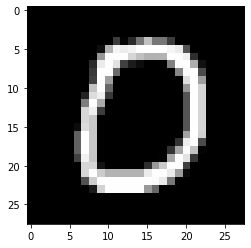

In [ ]:
cnn.eval()

one_image, label = val_dataset[10]
with torch.no_grad():
    new_pred = cnn(one_image.view(1,1,28,28))
    
print(new_pred.argmax()) 
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
plt.show()